# **Connecting the drive**

In [ ]:
#connecting to google drive
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


# **Importing libraries**

In [ ]:
#importing required libraries for loading dataset and processing
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import warnings
warnings.filterwarnings ('ignore')
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

**Loading the dataset**

In [ ]:
#loading dataset
fer_data = pd.read_csv("/content/drive/MyDrive/Deep learning project/fer2013.csv")
#first five records 
fer_data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


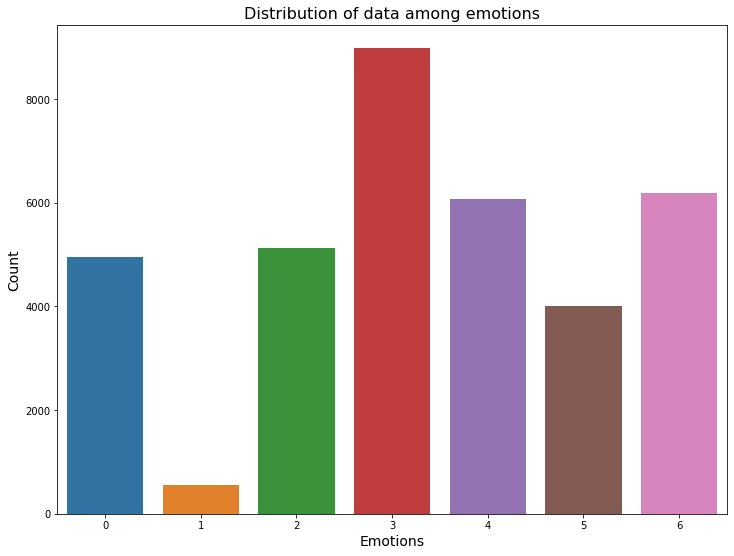

In [ ]:
plt.figure(figsize=(12, 9))
sns.countplot(fer_data['emotion'])
plt.title("Distribution of data among emotions", size=16)
plt.xlabel("Emotions", size=14)
plt.ylabel("Count", size=14)
plt.show()

In [ ]:
#labeling the emotions
emotion_dict = {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad',5: 'suprise', 6: 'neutral'}
width = 48
height = 48
classes = np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))
#categories of data that are present in usage feature
fer_data.Usage.value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

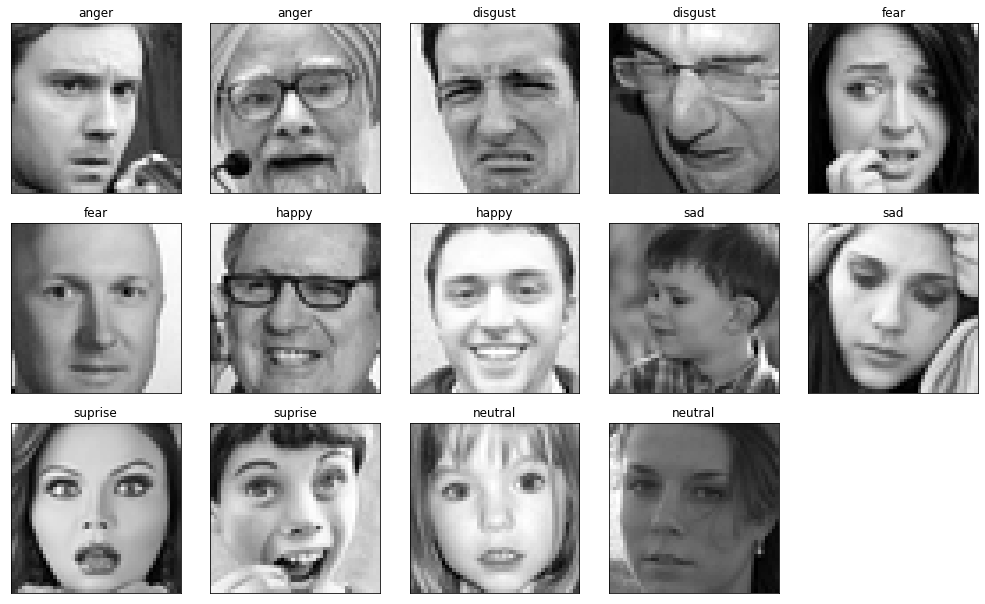

In [ ]:
#category and images that are present in the dataset
fig = plt.figure(7, (14, 14))
k = 0
for label in sorted(fer_data.emotion.unique()):
   #count of images that to be taken from each category
    for i in range(2):
        px = fer_data[fer_data.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(5,5, k)
        #plotting the images in grayscale 
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_dict[label])
        plt.tight_layout()

In [ ]:
#pixels of image
pixels = fer_data['pixels'].tolist()
#height and width
width, height = 48, 48
#image size
image_size=(48,48)
#layers to be in output
num_classes=7

In [ ]:
#changing the shape of image
temp = np.array(list(map(int,fer_data.iloc[0,1].split(" "))),dtype='uint8').reshape(image_size)
temp.shape

(48, 48)

In [ ]:
#creating empty lists to separate the data
X_train = []
y_train = []
X_test = []
y_test = []
for index, row in fer_data.iterrows():
    pixels = row['pixels'].split(" ")
    #training set
    if row['Usage'] == 'Training':
        X_train.append(np.array(pixels))
        y_train.append(row['emotion'])
        #validation set
    elif row['Usage'] == 'PublicTest':
        X_test.append(np.array(pixels))
        y_test.append(row['emotion'])

In [ ]:
#example from training dataset
X_train[7]

array(['77', '78', '79', ..., '125', '67', '68'], dtype='<U3')

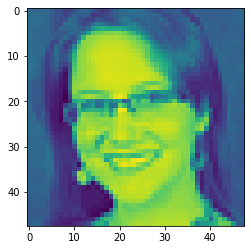

In [ ]:
#converting the numerical form of data present in pixels to image form
img = plt.imshow(np.array(X_train[7], dtype='uint8').reshape(48, 48))
img 

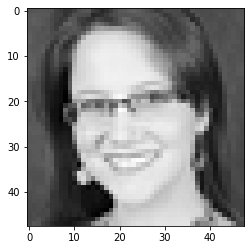

In [ ]:
#grayscale image
img = plt.imshow(np.array(X_train[7], dtype='uint8').reshape(48, 48), cmap='gray')
img 

In [ ]:
#trainand validation datasets
X_train = np.array(X_train, dtype = 'uint8')
y_train = np.array(y_train, dtype = 'uint8')
X_test = np.array(X_test, dtype = 'uint8')
y_test = np.array(y_test, dtype = 'uint8')

In [ ]:
#reshaping the size of images
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [ ]:
#number of images that are present in different set
print('Training Pixels',X_train.shape)
print('Training labels',y_train.shape)
print('Validation Pixels',X_test.shape)
print('Validation labels',y_test.shape)

Training Pixels (28709, 48, 48, 1)
Training labels (28709,)
Validation Pixels (3589, 48, 48, 1)
Validation labels (3589,)


In [ ]:
#converting the array of images to onehot encoding
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

**Image Augmentation**

In [ ]:
#for generating the data, image augmentation and normalizing the dataset
datagen = ImageDataGenerator(rescale=1./255, rotation_range = 10, horizontal_flip = True,
                             width_shift_range=0.1, height_shift_range=0.1, fill_mode = 'nearest')

testgen = ImageDataGenerator(rescale=1./255)
datagen.fit(X_train)
batch_size = 64

In [ ]:
#training dataset
train_data = datagen.flow(X_train, y_train, batch_size=batch_size)
#validation dataset
test_data = datagen.flow(X_test, y_test, batch_size=batch_size)

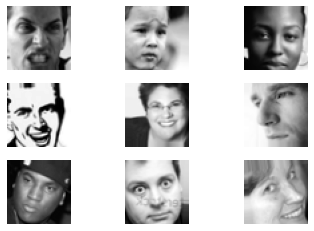

In [ ]:
#augmented images
for X_batch, y_batch in train_data:
    for i in range(0, 9): 
        plt.axis('off') 
        plt.subplot(330 + 1 + i) 
        plt.imshow(X_batch[i].reshape(48, 48), cmap=plt.get_cmap('gray'))
    plt.axis('off') 
    plt.show() 
    break

# **Creating model for training**

In [ ]:
#libraries required for building and training the model
from keras.models import Sequential, Model
from sklearn.metrics import confusion_matrix
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD 
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense

In [ ]:
#function that builds a cnn model
def emotion_recognition(input_shape=(48,48,1)):
    
    #first input model
    visible = Input(shape=input_shape, name='input')

    #Block 1
    conv1_1 = Conv2D(32, kernel_size=3, strides=(1,1),activation='relu', name = 'conv1_1')(visible)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_1)
    conv1_1 = BatchNormalization()(pool1_1)

    #Block 2
    conv2_1 = Conv2D(64, kernel_size=3, strides=(1,1),activation='relu',name = 'conv2_1')(conv1_1)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_1)
    conv2_1 = BatchNormalization()(pool2_1)

    #Block 3
    conv3_1 = Conv2D(128, kernel_size=3,strides=(1,1), activation='relu', name = 'conv3_1')(pool2_1)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_1)
    conv3_1 = BatchNormalization()(pool3_1)

    #flatten and output
    flatten = Flatten(name = 'flatten')(conv3_1)
    drop1 = Dense(1040, activation='relu', name = 'drop1')(flatten)
    drop2 = Dense(720, activation='relu', name = 'drop2')(drop1)
    ouput = Dense(7, activation='softmax', name = 'output')(drop2)

    #defining model 
    model = Model(inputs=visible, outputs=ouput)
    
    #summary
    print(model.summary())
    
    return model

In [ ]:
#calling the function
model = emotion_recognition()
#compiling the model with loss, metrics and oprimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 46, 46, 32)        320       
                                                                 
 pool1_1 (MaxPooling2D)      (None, 23, 23, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 32)       128       
 ormalization)                                                   
                                                                 
 conv2_1 (Conv2D)            (None, 21, 21, 64)        18496     
                                                                 
 pool2_1 (MaxPooling2D)      (None, 10, 10, 64)        0         
                                                             

In [ ]:
#for saving the imporvements in model weights at each point and to continue from that check points 
filepath = "weights_min_loss.hdf5"
checkpoint = ModelCheckpoint(filepath,monitor= 'val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [24]:
#number of epochs to be present in the model
num_epochs = 100
history = model.fit(train_data, steps_per_epoch=len(X_train) / batch_size, epochs=num_epochs,verbose=1, callbacks=callbacks_list, 
                    validation_data=test_data, validation_steps=len(X_test) / batch_size)

Epoch 1/100
448/448 [============================>.] - ETA: 0s - loss: 1.5781 - accuracy: 0.3845
Epoch 00001: val_loss improved from inf to 1.59858, saving model to weights_min_loss.hdf5
448/448 [==============================] - 30s 43ms/step - loss: 1.5778 - accuracy: 0.3847 - val_loss: 1.5986 - val_accuracy: 0.3814
Epoch 2/100
448/448 [============================>.] - ETA: 0s - loss: 1.3481 - accuracy: 0.4815
Epoch 00002: val_loss improved from 1.59858 to 1.34509, saving model to weights_min_loss.hdf5
448/448 [==============================] - 20s 44ms/step - loss: 1.3478 - accuracy: 0.4814 - val_loss: 1.3451 - val_accuracy: 0.4865
Epoch 3/100
448/448 [============================>.] - ETA: 0s - loss: 1.2694 - accuracy: 0.5146
Epoch 00003: val_loss did not improve from 1.34509
448/448 [==============================] - 20s 44ms/step - loss: 1.2695 - accuracy: 0.5146 - val_loss: 1.4437 - val_accuracy: 0.4480
Epoch 4/100
448/448 [============================>.] - ETA: 0s - loss: 1.21

In [25]:
#total loss and accuracy in training the dataset on test set
score = model.evaluate(X_test/255., y_test, verbose=1) 
print("Test Loss: ", (score[0]))
print("Test Accuracy: ",  score[1]*100)

113/113 [==============================] - 1s 7ms/step - loss: 1.7353 - accuracy: 0.6328
Test Loss:  1.7353410720825195
Test Accuracy:  63.27667832374573


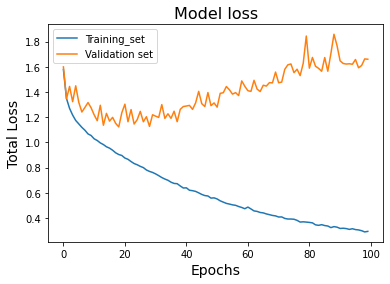

In [27]:
#plotting the model loss of training and test dataset
plt.plot(history.history['loss'], label="Training_set")
plt.plot(history.history['val_loss'], label="Validation set")
plt.title("Model loss", size=16)
plt.ylabel("Total Loss", size=14)
plt.xlabel("Epochs", size=14)
plt.legend()
plt.show()

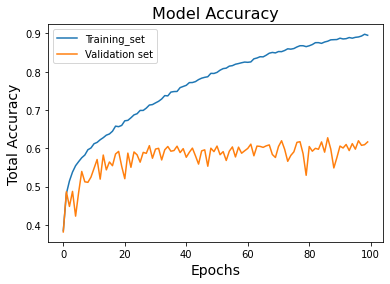

In [29]:
#plotting the model accuracy of training and test dataset
plt.plot(history.history['accuracy'], label="Training_set")
plt.plot(history.history['val_accuracy'], label="Validation set")
plt.title("Model Accuracy", size=16)
plt.ylabel("Total Accuracy", size=14)
plt.xlabel("Epochs", size=14)
plt.legend()
plt.show()

In [ ]:
#saving the model weights and configurations
model.save('../working/Fer2013.h5')

In [ ]:
#for testing the model on realtime images
from keras.preprocessing import image

def pred_emotion(img_path):
  img_path = img_path
  img = image.load_img(img_path, grayscale=True, target_size=(48,48))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  prediction = np.argmax(model.predict(x))
  print('The predicted emotion is : ' + emotion_dict[prediction])
  my_image = image.load_img(img_path)
  plt.imshow(my_image)
  result = plt.show()
  return result

The predicted emotion is : sad


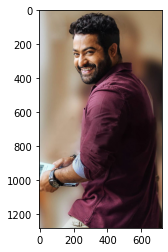

In [ ]:
pred_emotion("/content/drive/MyDrive/Deep learning project/jr1.jpeg")

The predicted emotion is : happy


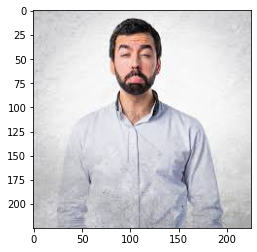

In [ ]:
pred_emotion("/content/drive/MyDrive/Deep learning project/")

In [ ]:
#saving the model's weights and configurations
from keras.models import Model, model_from_json
#json format
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
#h5 format
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
